In [1]:
import numpy as np
import sklearn

import gensim
import nltk

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

C:\Anaconda3\envs\py2\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
# 打开nltk的下载面板，并选中"Corpora"面板，在其中找到stopwords一栏，完成下载。
nltk.download()

# Load data
1. 从sklearn自带的数据库中获取想要的20newsgroup数据集。
2. 通过CMU维护查看相关文档，对该语料有一个基本了解。20个主题可以粗略地分为6个大类。![categories](./categories.png)
3. 在本次实验中，我从每个大分类中选择一个子分类，一共6个分类，构成本次实验所使用的数据集。

In [2]:
from sklearn.datasets import fetch_20newsgroups
import logging

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# manually select 6 categories from dataset.
categories = ["comp.os.ms-windows.misc", "misc.forsale", "rec.sport.baseball", "sci.space",
              "talk.politics.mideast", "alt.atheism"]

# remove some maybe useless parts from each text file.
# removes = ("headers", "footers", "quotes")

train_set = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, 
                               random_state=422)

test_set = fetch_20newsgroups(subset='test', categories=categories, shuffle=True,
                               random_state=422)

In [3]:
def splitData(data):
    return data.data, data.target

train_X, train_y = splitData(train_set)
test_X, test_y = splitData(test_set)

In [4]:
print "train set have " + str(len(train_X))
print "test set have " + str(len(test_X))

train set have 3410
test set have 2270


In [5]:
# 查看训练集中是否存在空文档

lens = np.array([len(item) for item in train_X])

empty_idx = np.where(lens==0)[0]

print empty_idx

[]


In [6]:
len(empty_idx)

0

In [7]:
test_lens = np.array([len(item) for item in test_X])

test_empty = np.where(test_lens==0)[0]

len(test_empty)

0

# Visualization 

查看原数据集中不同类别的分布情况。

In [8]:
train_y[:10]

array([2, 0, 1, 4, 4, 3, 4, 1, 5, 5], dtype=int64)

In [9]:
train_set.filenames[:10]

array([ 'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\misc.forsale\\75964',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\alt.atheism\\49960',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\comp.os.ms-windows.misc\\9520',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\sci.space\\60916',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\sci.space\\60950',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\rec.sport.baseball\\104449',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\sci.space\\61043',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\comp.os.ms-windows.misc\\9496',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-train\\talk.politics.mideast\\76311',
       'C:\\Users\\king\\scikit_learn_data\\20news_home\\20news-bydate-tr

在从sklearn中引入数据集的时候，加入了随机性， 并且所有的分类标签被用数字简化代替，这是数据挖掘中惯用的方法。现在，通过手工查看数据集中一小部分的情况，将“文本标签”和“数字标签”匹配。

查看 'train_set'中的前10个数据集，可以看到有如下匹配：
{"misc.forsale": 2
 "alt.atheism": 0
 "comp.os.ms-windows.misc": 1
 "sci.space": 4
 "rec.sport.baseball": 3
 "talk.politics.mideast": 5
}

In [10]:
# 生成从“文字标签”到“数字标签”之间的映射
labels = ["alt.atheism", "comp.os.ms-windows.misc", "misc.forsale",
          "rec.sport.baseball", "sci.space", "talk.politics.mideast"]

label_paris = {k:i for i, k in enumerate(labels)}

label_paris

{'alt.atheism': 0,
 'comp.os.ms-windows.misc': 1,
 'misc.forsale': 2,
 'rec.sport.baseball': 3,
 'sci.space': 4,
 'talk.politics.mideast': 5}

In [11]:
# 统计训练集总，各种类别的数据的出现次数
from collections import Counter

train_occurs = Counter(train_y)
# train_occurs的标签是数字标签，现转换为文字标签。
labels_counts = {k: train_occurs[label_paris[k]] for k in label_paris}

labels_counts

{'alt.atheism': 480,
 'comp.os.ms-windows.misc': 591,
 'misc.forsale': 585,
 'rec.sport.baseball': 597,
 'sci.space': 593,
 'talk.politics.mideast': 564}

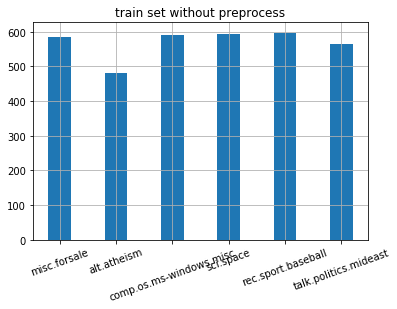

In [125]:
plt.bar(range(len(labels_counts)), labels_counts.values(), width=0.4)
plt.xticks(range(len(labels_counts)), labels_counts.keys(), rotation=20)
plt.title("train set without preprocess")
plt.grid()
plt.show()

In [123]:
def show_categories(labels, title):
    occurs = Counter(labels)
    labels_counts = {k: occurs[label_paris[k]] for k in label_paris}
    
    plt.bar(range(len(labels_counts)), labels_counts.values(), width=0.4)
    plt.xticks(range(len(labels_counts)), labels_counts.keys(), rotation=20)
    plt.title(title)
    plt.grid()
    
    plt.show()

查看测试集上的数据分布情况

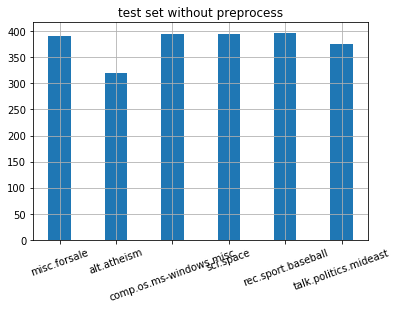

In [124]:
show_categories(test_y, "test set without preprocess")

上图展示了在使用的训练集中，各种类别文档的数目。我们可以初步认为，我们所使用的数据集在大致上是平衡的，不存在很严重的偏倚情况。

# Preprocessing Text 

1. 去除每一条文本中的非字母字符，切分割为单个单词。
2. 去除"Stopwords".
3. 使用Stemmer方法合并形态上相同的词，从而进一步降低特征维度。

# 随机选择一条文档，进行处理工作

In [65]:
text = train_X[23]

text

u'From: rdi@cci632.cci.com (Rick Inzero)\nSubject: Drafting Machine for sale\nOrganization: [Computer Consoles, Inc., Rochester, NY\nDistribution: usa\nLines: 17\n\nFor sale:  Precision drafting machine, Bruning OGP-0180.  Solid\nolder model with spring-loaded counter balance; clamps on table.  Without\nscales.  For right handed person.  $60/make offer, includes UPS/parcel post \npostage.\n\nI\'m guessing that it\'s from the 1940s or 1950s, a period well known for \nexcellent drafting machine construction! :-)\nIt\'s built with real metal parts, not cheap modern plastic, and it\'s painted \nthe typical office grey popular in that period.  It\'s smooth working, and \neach of the two "arms" on it measures roughly 24".  It has a dual clamp to \nenable you to clamp it on the edge or corner of a table.\n\n---\nRick Inzero\t\t\t\t        rochester!cci632!rdi\nNorthern Telecom, LTD       \t\t\tuunet!ccicpg!cci632!rdi\nRochester, NY\t\t\t\t\trdi@cci.com\n\n'

In [66]:
# 移除非字母部分
import re
text = text.lower()
text = re.sub("[^a-zA-Z]", " ", text)

In [67]:
text

u'from  rdi cci    cci com  rick inzero  subject  drafting machine for sale organization   computer consoles  inc   rochester  ny distribution  usa lines      for sale   precision drafting machine  bruning ogp        solid older model with spring loaded counter balance  clamps on table   without scales   for right handed person       make offer  includes ups parcel post  postage   i m guessing that it s from the     s or     s  a period well known for  excellent drafting machine construction      it s built with real metal parts  not cheap modern plastic  and it s painted  the typical office grey popular in that period   it s smooth working  and  each of the two  arms  on it measures roughly       it has a dual clamp to  enable you to clamp it on the edge or corner of a table       rick inzero            rochester cci    rdi northern telecom  ltd          uunet ccicpg cci    rdi rochester  ny     rdi cci com  '

In [68]:
raw_words = text.split(" ")
raw_words

[u'from',
 u'',
 u'rdi',
 u'cci',
 u'',
 u'',
 u'',
 u'cci',
 u'com',
 u'',
 u'rick',
 u'inzero',
 u'',
 u'subject',
 u'',
 u'drafting',
 u'machine',
 u'for',
 u'sale',
 u'organization',
 u'',
 u'',
 u'computer',
 u'consoles',
 u'',
 u'inc',
 u'',
 u'',
 u'rochester',
 u'',
 u'ny',
 u'distribution',
 u'',
 u'usa',
 u'lines',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'for',
 u'sale',
 u'',
 u'',
 u'precision',
 u'drafting',
 u'machine',
 u'',
 u'bruning',
 u'ogp',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'solid',
 u'older',
 u'model',
 u'with',
 u'spring',
 u'loaded',
 u'counter',
 u'balance',
 u'',
 u'clamps',
 u'on',
 u'table',
 u'',
 u'',
 u'without',
 u'scales',
 u'',
 u'',
 u'for',
 u'right',
 u'handed',
 u'person',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'make',
 u'offer',
 u'',
 u'includes',
 u'ups',
 u'parcel',
 u'post',
 u'',
 u'postage',
 u'',
 u'',
 u'i',
 u'm',
 u'guessing',
 u'that',
 u'it',
 u's',
 u'from',
 u'the',
 u'',
 u'',
 u'',
 u'',
 u's',
 u'or',
 u'',
 u'',
 u'',
 u'',
 u'

In [69]:
len(raw_words)

260

In [70]:
# remove all empty space

words = [w for w in raw_words if w != '']
words

[u'from',
 u'rdi',
 u'cci',
 u'cci',
 u'com',
 u'rick',
 u'inzero',
 u'subject',
 u'drafting',
 u'machine',
 u'for',
 u'sale',
 u'organization',
 u'computer',
 u'consoles',
 u'inc',
 u'rochester',
 u'ny',
 u'distribution',
 u'usa',
 u'lines',
 u'for',
 u'sale',
 u'precision',
 u'drafting',
 u'machine',
 u'bruning',
 u'ogp',
 u'solid',
 u'older',
 u'model',
 u'with',
 u'spring',
 u'loaded',
 u'counter',
 u'balance',
 u'clamps',
 u'on',
 u'table',
 u'without',
 u'scales',
 u'for',
 u'right',
 u'handed',
 u'person',
 u'make',
 u'offer',
 u'includes',
 u'ups',
 u'parcel',
 u'post',
 u'postage',
 u'i',
 u'm',
 u'guessing',
 u'that',
 u'it',
 u's',
 u'from',
 u'the',
 u's',
 u'or',
 u's',
 u'a',
 u'period',
 u'well',
 u'known',
 u'for',
 u'excellent',
 u'drafting',
 u'machine',
 u'construction',
 u'it',
 u's',
 u'built',
 u'with',
 u'real',
 u'metal',
 u'parts',
 u'not',
 u'cheap',
 u'modern',
 u'plastic',
 u'and',
 u'it',
 u's',
 u'painted',
 u'the',
 u'typical',
 u'office',
 u'grey',
 u'po

In [71]:
len(words)

145

In [72]:
from nltk.corpus import stopwords

# 移除停用词

stops = set(stopwords.words("english"))
words = [w for w in words if w not in stops]

In [73]:
words

[u'rdi',
 u'cci',
 u'cci',
 u'com',
 u'rick',
 u'inzero',
 u'subject',
 u'drafting',
 u'machine',
 u'sale',
 u'organization',
 u'computer',
 u'consoles',
 u'inc',
 u'rochester',
 u'ny',
 u'distribution',
 u'usa',
 u'lines',
 u'sale',
 u'precision',
 u'drafting',
 u'machine',
 u'bruning',
 u'ogp',
 u'solid',
 u'older',
 u'model',
 u'spring',
 u'loaded',
 u'counter',
 u'balance',
 u'clamps',
 u'table',
 u'without',
 u'scales',
 u'right',
 u'handed',
 u'person',
 u'make',
 u'offer',
 u'includes',
 u'ups',
 u'parcel',
 u'post',
 u'postage',
 u'guessing',
 u'period',
 u'well',
 u'known',
 u'excellent',
 u'drafting',
 u'machine',
 u'construction',
 u'built',
 u'real',
 u'metal',
 u'parts',
 u'cheap',
 u'modern',
 u'plastic',
 u'painted',
 u'typical',
 u'office',
 u'grey',
 u'popular',
 u'period',
 u'smooth',
 u'working',
 u'two',
 u'arms',
 u'measures',
 u'roughly',
 u'dual',
 u'clamp',
 u'enable',
 u'clamp',
 u'edge',
 u'corner',
 u'table',
 u'rick',
 u'inzero',
 u'rochester',
 u'cci',
 u'r

In [74]:
len(words)

97

In [75]:
len(stops), stops

(153,
 {u'a',
  u'about',
  u'above',
  u'after',
  u'again',
  u'against',
  u'ain',
  u'all',
  u'am',
  u'an',
  u'and',
  u'any',
  u'are',
  u'aren',
  u'as',
  u'at',
  u'be',
  u'because',
  u'been',
  u'before',
  u'being',
  u'below',
  u'between',
  u'both',
  u'but',
  u'by',
  u'can',
  u'couldn',
  u'd',
  u'did',
  u'didn',
  u'do',
  u'does',
  u'doesn',
  u'doing',
  u'don',
  u'down',
  u'during',
  u'each',
  u'few',
  u'for',
  u'from',
  u'further',
  u'had',
  u'hadn',
  u'has',
  u'hasn',
  u'have',
  u'haven',
  u'having',
  u'he',
  u'her',
  u'here',
  u'hers',
  u'herself',
  u'him',
  u'himself',
  u'his',
  u'how',
  u'i',
  u'if',
  u'in',
  u'into',
  u'is',
  u'isn',
  u'it',
  u'its',
  u'itself',
  u'just',
  u'll',
  u'm',
  u'ma',
  u'me',
  u'mightn',
  u'more',
  u'most',
  u'mustn',
  u'my',
  u'myself',
  u'needn',
  u'no',
  u'nor',
  u'not',
  u'now',
  u'o',
  u'of',
  u'off',
  u'on',
  u'once',
  u'only',
  u'or',
  u'other',
  u'our',
  u'ou

In [76]:
def sentece2words(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    raw_words = text.split(" ")
    words = [w for w in raw_words if w != '']
    words = [w for w in words if w not in stops]
    return words

In [77]:
text2 = train_X[56]

In [78]:
text2

u'From: mathew <mathew@mantis.co.uk>\nSubject: Re: university violating separation of church/state?\nOrganization: Mantis Consultants, Cambridge. UK.\nX-Newsreader: rusnews v1.01\nLines: 29\n\ndmn@kepler.unh.edu (...until kings become philosophers or philosophers become kings) writes:\n>      Recently, RAs have been ordered (and none have resisted or cared about\n> it apparently) to post a religious flyer entitled _The Soul Scroll: Thoughts\n> on religion, spirituality, and matters of the soul_ on the inside of bathroom\n> stall doors. (at my school, the University of New Hampshire) It is some sort\n> of newsletter assembled by a Hall Director somewhere on campus. It poses a\n> question about \'spirituality\' each issue, and solicits responses to be \n> included in the next \'issue.\' It\'s all pretty vague. I assume it\'s put out\n> by a Christian, but they\'re very careful not to mention Jesus or the bible.\n> I\'ve heard someone defend it, saying "Well it doesn\'t support any one re

In [79]:
sentece2words(text2)

[u'mathew',
 u'mathew',
 u'mantis',
 u'co',
 u'uk',
 u'subject',
 u'university',
 u'violating',
 u'separation',
 u'church',
 u'state',
 u'organization',
 u'mantis',
 u'consultants',
 u'cambridge',
 u'uk',
 u'x',
 u'newsreader',
 u'rusnews',
 u'v',
 u'lines',
 u'dmn',
 u'kepler',
 u'unh',
 u'edu',
 u'kings',
 u'become',
 u'philosophers',
 u'philosophers',
 u'become',
 u'kings',
 u'writes',
 u'recently',
 u'ras',
 u'ordered',
 u'none',
 u'resisted',
 u'cared',
 u'apparently',
 u'post',
 u'religious',
 u'flyer',
 u'entitled',
 u'soul',
 u'scroll',
 u'thoughts',
 u'religion',
 u'spirituality',
 u'matters',
 u'soul',
 u'inside',
 u'bathroom',
 u'stall',
 u'doors',
 u'school',
 u'university',
 u'new',
 u'hampshire',
 u'sort',
 u'newsletter',
 u'assembled',
 u'hall',
 u'director',
 u'somewhere',
 u'campus',
 u'poses',
 u'question',
 u'spirituality',
 u'issue',
 u'solicits',
 u'responses',
 u'included',
 u'next',
 u'issue',
 u'pretty',
 u'vague',
 u'assume',
 u'put',
 u'christian',
 u'careful'

观察上述记录，我认为单词长度小于3的可以被剔除，至少从字面上来看，没有实际意义。

In [80]:
def sent2words(text):
    """
    tokenization a single text into words list.
    """
    words = sentece2words(text)
    return [w for w in words if len(w) > 2]

In [81]:
sent2words(text2)

[u'mathew',
 u'mathew',
 u'mantis',
 u'subject',
 u'university',
 u'violating',
 u'separation',
 u'church',
 u'state',
 u'organization',
 u'mantis',
 u'consultants',
 u'cambridge',
 u'newsreader',
 u'rusnews',
 u'lines',
 u'dmn',
 u'kepler',
 u'unh',
 u'edu',
 u'kings',
 u'become',
 u'philosophers',
 u'philosophers',
 u'become',
 u'kings',
 u'writes',
 u'recently',
 u'ras',
 u'ordered',
 u'none',
 u'resisted',
 u'cared',
 u'apparently',
 u'post',
 u'religious',
 u'flyer',
 u'entitled',
 u'soul',
 u'scroll',
 u'thoughts',
 u'religion',
 u'spirituality',
 u'matters',
 u'soul',
 u'inside',
 u'bathroom',
 u'stall',
 u'doors',
 u'school',
 u'university',
 u'new',
 u'hampshire',
 u'sort',
 u'newsletter',
 u'assembled',
 u'hall',
 u'director',
 u'somewhere',
 u'campus',
 u'poses',
 u'question',
 u'spirituality',
 u'issue',
 u'solicits',
 u'responses',
 u'included',
 u'next',
 u'issue',
 u'pretty',
 u'vague',
 u'assume',
 u'put',
 u'christian',
 u'careful',
 u'mention',
 u'jesus',
 u'bible',
 

In [82]:
def preprocess(data):
    res = []
    for text in data:
        words = sent2words(text)
        res.append(words)
    return res

In [83]:
train_X_processed = preprocess(train_X)

In [84]:
# 检查经过预处理之后的数据集的情况
print len(train_X_processed) == len(train_y)

True


In [85]:
# 查看经过预处理后的每一条news中的单词数量。
lens = np.array([len(content) for content in train_X_processed])

In [86]:
len(lens)

3410

In [87]:
lens

array([  54, 1052,   90, ...,   46,  146,  125])

In [88]:
# 查看单词数量最多的一条记录
max_idx = np.where(max(lens) == lens)[0][0]

max_words = train_X_processed[max_idx]

In [89]:
len(max_words)

4758

In [90]:
train_X_processed[max_idx]

[u'dbd',
 u'urartu',
 u'sdpa',
 u'org',
 u'david',
 u'davidian',
 u'subject',
 u'accounts',
 u'anti',
 u'armenian',
 u'human',
 u'right',
 u'violations',
 u'azerbaijan',
 u'summary',
 u'part',
 u'organization',
 u'center',
 u'regional',
 u'studies',
 u'lines',
 u'accounts',
 u'anti',
 u'armenian',
 u'human',
 u'right',
 u'violations',
 u'azerbaijan',
 u'part',
 u'prelude',
 u'current',
 u'events',
 u'nagorno',
 u'karabakh',
 u'part',
 u'yes',
 u'remembered',
 u'raping',
 u'repeated',
 u'quite',
 u'frequently',
 u'let',
 u'armenian',
 u'women',
 u'babies',
 u'muslim',
 u'babies',
 u'let',
 u'bear',
 u'azerbaijanis',
 u'struggle',
 u'armenians',
 u'said',
 u'muslims',
 u'carry',
 u'holy',
 u'cause',
 u'heroes',
 u'repeated',
 u'often',
 u'continued',
 u'part',
 u'six',
 u'left',
 u'left',
 u'attack',
 u'realized',
 u'dan',
 u'ger',
 u'past',
 u'stopped',
 u'controlling',
 u'relaxed',
 u'moment',
 u'physical',
 u'pain',
 u'immediately',
 u'made',
 u'felt',
 u'heart',
 u'kidneys',
 u'hurt'

In [91]:
# 查看是否存在长度为0的内容
zero_idx = np.where(lens==0)
zero_idx

(array([], dtype=int64),)

不存在长度为0的项

In [92]:
# 查看长度最小的内容
min_idx = np.where(lens == min(lens))[0][0]

min_words = train_X_processed[min_idx]

In [93]:
len(min_words)

13

In [102]:
# 查看所有文档的平均单词量

avg = np.mean(lens)
avg

165.16422287390029

计算明显的单词数较多的样本点的数量, 假设绝大多数数据样本的单词量在10000以内。

使用相同的方法处理测试数据集

In [103]:
test_X_processed = preprocess(test_X)

使用相同的方法查看测试集上的单词情况

In [104]:
test_lens = np.array([len(content) for content in test_X_processed])

len(test_lens)

2270

In [105]:
test_max_len = max(test_lens)

test_max_len

6188

In [106]:
test_max_idx = np.where(test_max_len == test_lens)[0][0]

test_max_idx

1340

In [107]:
test_X_processed[1644]

[u'brian',
 u'quake',
 u'sylmar',
 u'subject',
 u'government',
 u'science',
 u'technolgy',
 u'investment',
 u'organization',
 u'quake',
 u'public',
 u'access',
 u'san',
 u'fernando',
 u'valley',
 u'lines',
 u'article',
 u'pgf',
 u'srl',
 u'cacs',
 u'usl',
 u'edu',
 u'pgf',
 u'srl',
 u'cacs',
 u'usl',
 u'edu',
 u'phil',
 u'fraering',
 u'writes',
 u'mccolm',
 u'darwin',
 u'math',
 u'usf',
 u'edu',
 u'gregory',
 u'mccolm',
 u'writes',
 u'article',
 u'rice',
 u'edu',
 u'conor',
 u'owlnet',
 u'rice',
 u'edu',
 u'conor',
 u'frederick',
 u'prischmann',
 u'writes',
 u'article',
 u'srfii',
 u'suntan',
 u'eng',
 u'usf',
 u'edu',
 u'mccolm',
 u'darwin',
 u'math',
 u'usf',
 u'edu',
 u'gregory',
 u'mccolm',
 u'writes',
 u'huh',
 u'please',
 u'state',
 u'criteria',
 u'selecting',
 u'greatest',
 u'philosopher',
 u'title',
 u'ever',
 u'read',
 u'nietzsche',
 u'greatest',
 u'likely',
 u'remembered',
 u'five',
 u'hundred',
 u'years',
 u'hence',
 u'must',
 u'admit',
 u'makes',
 u'many',
 u'personal',
 u'

查看该文件的内容，发现由许多奇怪的长度为3的字符串，从字面上看并没有任何实际意义。

先仔细查看其中的内容

In [108]:
text = train_X[1644]

In [109]:
text

u'From: jboro@enterprise.bih.harvard.edu (Jason Boro)\nSubject: 2 PC\'s, chair & typewriter in Boston\nOrganization: Center for Clinical Computing - Boston, MA.\nLines: 27\nDistribution: world\nNNTP-Posting-Host: cheever.bih.harvard.edu\n\n1. IBM PS/2 286; 30 meg hd; 1.44 disk drive 3.5"; extended keyboard; mouse,\n   mouse-pad; DOS, DOSSHELL, EXCEL, WINDO S, WORD, AMIPRO, GRE StudyWare.\n   $500 / b.o.\n\n2.  Zenith Date Systems supersport laptop computer\n    w/ 120V AC recharger; model 150-308 60 hz.\n    DOS 4.0\n    2 disc drives for 3.5" floppy\n    carrying case, manuals.\n    $350 / b.o.\n\n3.  2 leather desk chairs  (1) black $200. (2) brown $150. or both for\n$300.\n\n4.  Olivetti manual typewriter, Tropical model.\n    Incl. characters for typing in Italian language.\n    $100.\n\nPlease reply via email or call me at my home number:  (617) 277-9234.\n\nThanks,\nJason\n\n*---------------------------------------------------------------------*\n| Jason Boro ....................

In [110]:
text = text.lower()
text = re.sub("[^a-zA-Z]", " ", text)

text

u'from  jboro enterprise bih harvard edu  jason boro  subject    pc s  chair   typewriter in boston organization  center for clinical computing   boston  ma  lines     distribution  world nntp posting host  cheever bih harvard edu     ibm ps           meg hd       disk drive       extended keyboard  mouse     mouse pad  dos  dosshell  excel  windo s  word  amipro  gre studyware            b o       zenith date systems supersport laptop computer     w     v ac recharger  model            hz      dos           disc drives for      floppy     carrying case  manuals             b o         leather desk chairs      black           brown       or both for            olivetti manual typewriter  tropical model      incl  characters for typing in italian language             please reply via email or call me at my home number                    thanks  jason                                                                            jason boro                         jboro enterprise bih harvard

姑且认为这些缩写，是某些特定领域的专有名词，现忽略。

In [111]:
# 查看是否存在长度为0的内容
test_zero_idx = np.where(lens==0)
test_zero_idx

(array([], dtype=int64),)

In [112]:
test_min_len = min(test_lens)

test_min_len

12

In [113]:
test_min_idx = np.where(test_lens == test_min_len)[0][0]

test_min_idx

1522

In [114]:
test_X_processed[test_min_idx]

[u'edwin',
 u'gans',
 u'subject',
 u'atheism',
 u'nntp',
 u'posting',
 u'host',
 u'organization',
 u'bell',
 u'northern',
 u'research',
 u'lines']

In [115]:
test_avg = np.mean(test_lens)

test_avg

163.68281938325993

In [116]:
count_less1000 = np.sum(lens < 1000)
ratio = count_less1000 / float(len(lens))

print ratio

0.981818181818


In [126]:
test_count_less1000 = np.sum(test_lens < 1000)
ratio = test_count_less1000 / float(len(test_lens))

ratio

0.98722466960352417

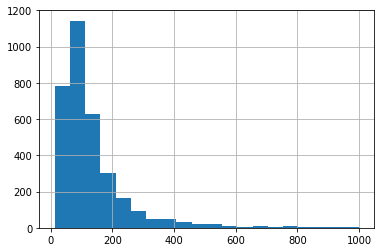

In [127]:
plt.hist(lens, bins=20, range=(lens.min(), 1000))
plt.grid()
plt.show()

In [128]:
def show_count(data, title):
    lens = np.array([len(cont) for cont in data])
    plt.hist(lens, bins=20, range=(lens.min(), 1000))
    plt.title(title)
    plt.grid()
    plt.show()

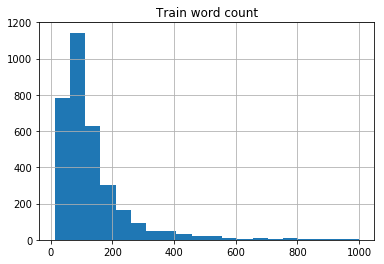

In [129]:
show_count(train_X_processed, "Train word count")

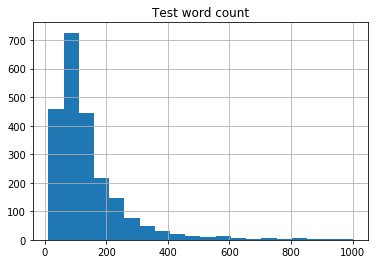

In [130]:
show_count(test_X_processed, "Test word count")

可以从上图看出，对于数据集中每个样本的单词数量分布而言，也是近似的。虽然在测试集上的单词量要少于训练集。

# Feature Extraction

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer

td_vector = TfidfVectorizer()

TfidfVectorizer的输入数据应该是字符串，首先将每个单词列表转换会字符串。

In [132]:
def convert2str_aux(lst):
        return " ".join(lst)

In [133]:
text = train_X_processed[23]

In [134]:
len(text)

95

In [135]:
convert2str_aux(text)

u'rdi cci cci com rick inzero subject drafting machine sale organization computer consoles inc rochester distribution usa lines sale precision drafting machine bruning ogp solid older model spring loaded counter balance clamps table without scales right handed person make offer includes ups parcel post postage guessing period well known excellent drafting machine construction built real metal parts cheap modern plastic painted typical office grey popular period smooth working two arms measures roughly dual clamp enable clamp edge corner table rick inzero rochester cci rdi northern telecom ltd uunet ccicpg cci rdi rochester rdi cci com'

In [136]:
def convert2str(data):
    
    return [convert2str_aux(lst) for lst in data]

In [137]:
train_X_str = convert2str(train_X_processed)

In [138]:
train_X_str[5]

u'vince sscl uwo subject early bbddd returns organization social science computing laboratory nntp posting host vaxi sscl uwo lines article apr news brandeis edu pip brandeis edu adam levin writes curious anyone started standout early season ddd year concerned fan ddd hoping produce first update ddd week please send info significant longest critical etc home run seen yet season vince'

In [139]:
test_X_str = convert2str(test_X_processed)

In [140]:
train_tfidf = td_vector.fit_transform(train_X_str).toarray()

In [141]:
type(train_tfidf), train_tfidf.shape

(numpy.ndarray, (3410L, 48638L))

In [142]:
vocabulary = td_vector.get_feature_names()

vocabulary

[u'aaa',
 u'aaaaagggghhhh',
 u'aaaarrgghhhh',
 u'aaf',
 u'aah',
 u'aaj',
 u'aalac',
 u'aaldoubo',
 u'aam',
 u'aamazing',
 u'aamrl',
 u'aams',
 u'aan',
 u'aanbieden',
 u'aangegeven',
 u'aangezien',
 u'aanp',
 u'aantal',
 u'aao',
 u'aaos',
 u'aap',
 u'aaph',
 u'aar',
 u'aardvark',
 u'aario',
 u'aarnet',
 u'aaron',
 u'aarseth',
 u'aas',
 u'aav',
 u'aavb',
 u'aavso',
 u'aaw',
 u'aax',
 u'aazaadee',
 u'aba',
 u'ababs',
 u'abacus',
 u'abaihm',
 u'abandon',
 u'abandonded',
 u'abandoned',
 u'abandoning',
 u'abberation',
 u'abbot',
 u'abbott',
 u'abbrev',
 u'abbreviation',
 u'abbreviations',
 u'abbs',
 u'abc',
 u'abcd',
 u'abcpv',
 u'abd',
 u'abdel',
 u'abdi',
 u'abdication',
 u'abdkw',
 u'abdo',
 u'abdomen',
 u'abdomens',
 u'abduct',
 u'abducted',
 u'abduction',
 u'abdul',
 u'abdulcebbar',
 u'abdulhamid',
 u'abdullah',
 u'abdullahad',
 u'abed',
 u'abedk',
 u'abensberg',
 u'abeoz',
 u'aber',
 u'aberdeen',
 u'aberration',
 u'abetter',
 u'abg',
 u'abgarovich',
 u'abh',
 u'abhor',
 u'abhorrences',

In [143]:
len(vocabulary)

48638

# Train models

从 "Student intervention" 项目中，拷贝其封装的用于测试和训练的方法，并加以修改，方便在本项目中试用不同的训练模型。

In [144]:
from time import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 


def train_classifier(clf, X_train, y_train):
    ''' 用训练集训练分类器 '''
    
    # 开始计时，训练分类器，然后停止计时
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds\n".format(end - start)

# 在此处添加indicator参数，用作性能指标评价方法
def predict_labels(clf, features, target):
    ''' 用训练好的分类器做预测并输出F1值'''
    
    # 开始计时，作出预测，然后停止计时
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # 输出并返回结果
    print "Made predictions in {:.4f} seconds.".format(end - start)
    f1 = f1_score(target, y_pred, average='macro')
    accuracy = accuracy_score(target, y_pred)
    return f1, accuracy


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' 用一个分类器训练和预测，并输出F1值和准确率 '''
    
    # 输出分类器名称和训练集大小
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # 训练一个分类器
    train_classifier(clf, X_train, y_train)
    
    train_f1, train_acc = predict_labels(clf, X_train, y_train)
    test_f1, test_acc = predict_labels(clf, X_test, y_test)
    print " "
    
    # 输出训练和测试的预测结果
    print "F1's score for training set: {:.4f}.".format(train_f1)
    print "Accuracy for training set: {:.4f}.".format(train_acc)
    print " "
    print "F1's score for test set: {:.4f}.".format(test_f1)
    print "Accuracy for test set: {:.4f}.".format(test_acc)
    print " "
    
    return train_acc, train_f1, test_acc, test_f1

In [145]:
from sklearn.naive_bayes import MultinomialNB

# The multinomial Naive Bayes classifier is 
# suitable for classification with discrete features 
# (e.g., word counts for text classification). 
# The multinomial distribution normally requires integer feature counts. 
# However, in practice, fractional counts such as tf-idf may also work.

model_1 = MultinomialNB()
test_tfidf = td_vector.transform(test_X_str).toarray()

train_predict(model_1, train_tfidf, train_y, test_tfidf, test_y)

Training a MultinomialNB using a training set size of 3410. . .
Trained model in 0.5640 seconds

Made predictions in 0.2940 seconds.
Made predictions in 0.2760 seconds.
 
F1's score for training set: 0.9947.
Accuracy for training set: 0.9947.
 
F1's score for test set: 0.9515.
Accuracy for test set: 0.9520.
 


(0.99472140762463346,
 0.99468908839820502,
 0.95198237885462555,
 0.95154814058581738)

In [146]:
from sklearn.svm import LinearSVC

model_2 = LinearSVC(random_state=422)

train_predict(model_2, train_tfidf, train_y, test_tfidf, test_y)

Training a LinearSVC using a training set size of 3410. . .
Trained model in 0.4870 seconds

Made predictions in 0.3090 seconds.
Made predictions in 0.1970 seconds.
 
F1's score for training set: 1.0000.
Accuracy for training set: 1.0000.
 
F1's score for test set: 0.9536.
Accuracy for test set: 0.9542.
 


(1.0, 1.0, 0.95418502202643174, 0.95364983718855278)

In [154]:
model_2.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 422,
 'tol': 0.0001,
 'verbose': 0}

对SVM模型进行GridSearch，试图寻找到好的模型

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

parameters = {"C": [1, 1.5, 2],
              "loss": ["hinge", "squared_hinge"],
              "tol":[0.1, 0.5]
              }

linear_svc = LinearSVC(random_state=422)
f1_scorer = make_scorer(fbeta_score, beta=1, pos_label='yes', average='macro')

grid_obj = GridSearchCV(linear_svc, parameters, f1_scorer)
grid_obj.fit(train_tfidf, train_y)

# Get the estimator
model_3 = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
# 输出经过调参之后的训练集和测试集的F1值
train_f1, train_acc = predict_labels(model_3, train_tfidf, train_y)
test_f1, test_acc = predict_labels(model_3, test_tfidf, test_y)
print "Tuned model has a training accuracy score of {:.4f}.".format(train_acc)
print "Tuned model has a training F1 score of {:.4f}.".format(train_f1)

print "Tuned model has a testing F1 score of {:.4f}.".format(test_f1)
print "Tuned model has a testing accuracy score of {:.4f}.".format(test_acc)

Made predictions in 0.3650 seconds.
Made predictions in 0.2850 seconds.
Tuned model has a training accuracy score of 1.0000.
Tuned model has a training F1 score of 1.0000.
Tuned model has a testing F1 score of 0.9555.
Tuned model has a testing accuracy score of 0.9559.


In [156]:
model_3.get_params()

{'C': 2,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 422,
 'tol': 0.5,
 'verbose': 0}

## 尝试使用卡方验证选择特征

In [194]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest


n_features = 1000
selector = SelectKBest(chi2, n_features)

train_X_features = selector.fit_transform(train_tfidf, train_y)
test_X_features = selector.transform(test_tfidf)

In [195]:
train_X_features.shape

(3410L, 1000L)

In [196]:
svc = LinearSVC(random_state=422)

train_predict(svc, train_X_features, train_y, test_X_features, test_y)

Training a LinearSVC using a training set size of 3410. . .
Trained model in 0.0650 seconds

Made predictions in 0.0100 seconds.
Made predictions in 0.0050 seconds.
 
F1's score for training set: 0.9798.
Accuracy for training set: 0.9795.
 
F1's score for test set: 0.9286.
Accuracy for test set: 0.9291.
 


(0.97947214076246336,
 0.97981824360598369,
 0.92907488986784137,
 0.92861287695516515)

In [197]:
nb_clf = MultinomialNB()

train_predict(nb_clf, train_X_features, train_y, test_X_features, test_y)

Training a MultinomialNB using a training set size of 3410. . .
Trained model in 0.0110 seconds

Made predictions in 0.0110 seconds.
Made predictions in 0.0070 seconds.
 
F1's score for training set: 0.9639.
Accuracy for training set: 0.9633.
 
F1's score for test set: 0.9340.
Accuracy for test set: 0.9344.
 


(0.96334310850439886,
 0.96389786620443207,
 0.93436123348017619,
 0.93398496537934361)

查看不同n_features的取值，对结果的影响程度, 在此处使用贝叶斯算法实验

In [198]:
nb_clf = MultinomialNB()

train_acc_lst, train_f1_lst = [], []
test_acc_lst, test_f1_lst = [], []

n_features = xrange(1000, 10500, 500)

for num in list(n_features):
    selector = SelectKBest(chi2, num)

    train_X_features = selector.fit_transform(train_tfidf, train_y)
    test_X_features = selector.transform(test_tfidf)
    print "n_feature is {}:".format(num)
    print " "
    train_acc, train_f1, test_acc, test_f1 = train_predict(nb_clf, train_X_features, train_y, test_X_features, test_y)
    train_acc_lst.append(train_acc)
    train_f1_lst.append(train_f1)
    test_acc_lst.append(test_acc)
    test_f1_lst.append(test_f1)

n_feature is 1000:
 
Training a MultinomialNB using a training set size of 3410. . .
Trained model in 0.0100 seconds

Made predictions in 0.0070 seconds.
Made predictions in 0.0040 seconds.
 
F1's score for training set: 0.9639.
Accuracy for training set: 0.9633.
 
F1's score for test set: 0.9340.
Accuracy for test set: 0.9344.
 
n_feature is 1500:
 
Training a MultinomialNB using a training set size of 3410. . .
Trained model in 0.0140 seconds

Made predictions in 0.0100 seconds.
Made predictions in 0.0070 seconds.
 
F1's score for training set: 0.9717.
Accuracy for training set: 0.9713.
 
F1's score for test set: 0.9392.
Accuracy for test set: 0.9396.
 
n_feature is 2000:
 
Training a MultinomialNB using a training set size of 3410. . .
Trained model in 0.0250 seconds

Made predictions in 0.0160 seconds.
Made predictions in 0.0120 seconds.
 
F1's score for training set: 0.9778.
Accuracy for training set: 0.9774.
 
F1's score for test set: 0.9393.
Accuracy for test set: 0.9396.
 
n_fe

In [199]:
train_acc_lst

[0.96334310850439886,
 0.97126099706744873,
 0.97741935483870968,
 0.98211143695014658,
 0.98651026392961871,
 0.98797653958944287,
 0.98768328445747799,
 0.98885630498533728,
 0.98914956011730204,
 0.99032258064516132,
 0.99061583577712609,
 0.99178885630498537,
 0.99208211143695013,
 0.99237536656891501,
 0.99266862170087977,
 0.99384164222873905,
 0.99413489736070382,
 0.99413489736070382,
 0.99442815249266858]

In [200]:
train_f1_lst

[0.96389786620443207,
 0.97170076856693777,
 0.97780689442221835,
 0.98239092443682952,
 0.98669115080616387,
 0.98813108722150922,
 0.98782306057327263,
 0.98895575463434982,
 0.98928603488559153,
 0.99041166633944622,
 0.99069642008045411,
 0.99182746295076674,
 0.99210913228905218,
 0.99239218461228118,
 0.99267532914091039,
 0.99384074346966622,
 0.99412320689697042,
 0.99412320689697042,
 0.99440741679102873]

In [201]:
test_acc_lst

[0.93436123348017619,
 0.93964757709251101,
 0.93964757709251101,
 0.94669603524229073,
 0.9493392070484582,
 0.95066079295154182,
 0.95330396475770929,
 0.95550660792951547,
 0.95462555066079291,
 0.95594713656387664,
 0.95550660792951547,
 0.95682819383259909,
 0.95770925110132155,
 0.95770925110132155,
 0.95770925110132155,
 0.95682819383259909,
 0.95638766519823792,
 0.95726872246696038,
 0.95506607929515419]

In [202]:
test_f1_lst

[0.93398496537934361,
 0.93924822228487681,
 0.9392725228682407,
 0.94649451675285812,
 0.94879273121155494,
 0.95007528044839606,
 0.95296365985093157,
 0.95505478329136995,
 0.95412056708713655,
 0.95564392662420961,
 0.9551572658075892,
 0.95651149384176615,
 0.95736855882673944,
 0.9574055308120889,
 0.95740817885993323,
 0.95648718765346441,
 0.95612161565066833,
 0.95697196983520616,
 0.95471285647117143]

#### 根据上述4个列表数值的情况可以得出结论，随着特征个数的增加，值都有所增加。增加特征数量，对提高分类的准确率有很大的帮助。
特征数量从1000涨到10000， 其在测试集上的表现的提高0.02左右。

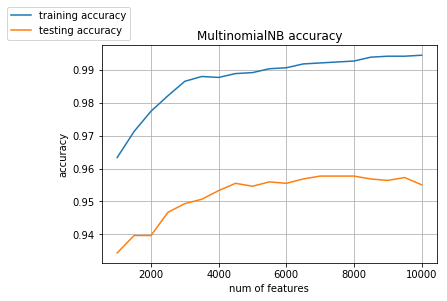

In [203]:
plt.plot(list(n_features), train_acc_lst, label='training accuracy')
plt.plot(list(n_features), test_acc_lst, label='testing accuracy')
plt.xlabel("num of features")
plt.ylabel("accuracy")
plt.legend(bbox_to_anchor=[0.1, 1.2])
plt.title("MultinomialNB accuracy")
plt.grid() 
plt.show()

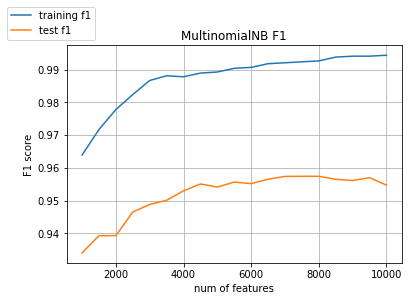

In [204]:
plt.plot(list(n_features), train_f1_lst, label='training f1')
plt.plot(list(n_features), test_f1_lst, label='test f1')
plt.xlabel("num of features")
plt.ylabel("F1 score")
plt.legend(bbox_to_anchor=[0.1, 1.2])
plt.title("MultinomialNB F1")
plt.grid() 
plt.show()

以'test_acc'为主要评价指标，试图找到test_acc最大的时候的features个数。

In [205]:
max_acc_idx = np.argmax(np.array(test_acc_lst))
best_features_num = list(n_features)[max_acc_idx]

best_features_num

7000

测试一下在其他模型上的性能

In [209]:
svc = LinearSVC(random_state=422)

def trainByMoreFeatures(clf, min_feature, max_feature):
    n_features = xrange(min_feature, max_feature, 500)
    train_acc_lst, train_f1_lst = [], []
    test_acc_lst, test_f1_lst = [], []
    
    for num in list(n_features):
        selector = SelectKBest(chi2, num)

        train_X_features = selector.fit_transform(train_tfidf, train_y)
        test_X_features = selector.transform(test_tfidf)
        print "n_feature is {}:".format(num)
        print " "
        train_acc, train_f1, test_acc, test_f1 = train_predict(clf, train_X_features, train_y, test_X_features, test_y)
        train_acc_lst.append(train_acc)
        train_f1_lst.append(train_f1)
        test_acc_lst.append(test_acc)
        test_f1_lst.append(test_f1)
    return train_acc_lst, train_f1_lst, test_acc_lst, test_f1_lst

train_acc_lst, train_f1_lst, test_acc_lst, test_f1_lst = trainByMoreFeatures(svc, 1000, 10500)

n_feature is 1000:
 
Training a LinearSVC using a training set size of 3410. . .
Trained model in 0.0510 seconds

Made predictions in 0.0070 seconds.
Made predictions in 0.0040 seconds.
 
F1's score for training set: 0.9798.
Accuracy for training set: 0.9795.
 
F1's score for test set: 0.9286.
Accuracy for test set: 0.9291.
 
n_feature is 1500:
 
Training a LinearSVC using a training set size of 3410. . .
Trained model in 0.0740 seconds

Made predictions in 0.0100 seconds.
Made predictions in 0.0070 seconds.
 
F1's score for training set: 0.9890.
Accuracy for training set: 0.9889.
 
F1's score for test set: 0.9370.
Accuracy for test set: 0.9374.
 
n_feature is 2000:
 
Training a LinearSVC using a training set size of 3410. . .
Trained model in 0.1230 seconds

Made predictions in 0.0130 seconds.
Made predictions in 0.0080 seconds.
 
F1's score for training set: 0.9925.
Accuracy for training set: 0.9924.
 
F1's score for test set: 0.9428.
Accuracy for test set: 0.9436.
 
n_feature is 250

In [210]:
test_acc_lst

[0.92907488986784137,
 0.93744493392070483,
 0.9436123348017621,
 0.94757709251101319,
 0.95154185022026427,
 0.94845814977973564,
 0.94801762114537447,
 0.95198237885462555,
 0.95286343612334801,
 0.95066079295154182,
 0.95418502202643174,
 0.95330396475770929,
 0.95506607929515419,
 0.95506607929515419,
 0.95506607929515419,
 0.95462555066079291,
 0.95550660792951547,
 0.95462555066079291,
 0.95594713656387664]

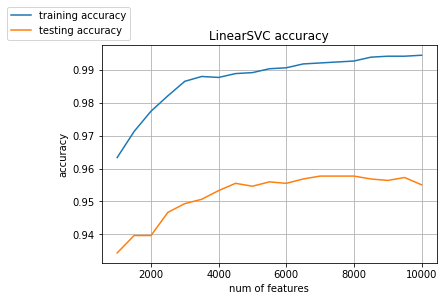

In [185]:
plt.plot(list(n_features), train_acc_lst, label='training accuracy')
plt.plot(list(n_features), test_acc_lst, label='testing accuracy')
plt.xlabel("num of features")
plt.ylabel("accuracy")
plt.legend(bbox_to_anchor=[0.1, 1.2])
plt.title("LinearSVC accuracy")
plt.grid()
plt.show()

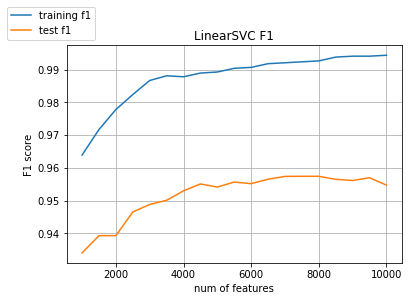

In [186]:
plt.plot(list(n_features), train_f1_lst, label='training f1')
plt.plot(list(n_features), test_f1_lst, label='test f1')
plt.xlabel("num of features")
plt.ylabel("F1 score")
plt.legend(bbox_to_anchor=[0.1, 1.2])
plt.title("LinearSVC F1")
plt.grid()
plt.show()

In [211]:
max_acc_idx = np.argmax(np.array(test_acc_lst))

In [215]:
svc_best_features = np.array(list(n_features))[max_acc_idx]

svc_best_features

10000

- 对于MultinomialNB模型，当特征维度为7000的时候，模型能够在测试集上取得最大的Accuracy.

- 对于LinearSVC模型，当特征为度为10000的时候，模型能够在测试集上取得最大的Accuracy.

In [218]:
k_features = 7000

selector = SelectKBest(chi2, k_features)

train_X_features = selector.fit_transform(train_tfidf, train_y)
test_X_features = selector.transform(test_tfidf)
              
model_4 = MultinomialNB()

train_predict(model_4, train_X_features, train_y, test_X_features, test_y)

Training a MultinomialNB using a training set size of 3410. . .
Trained model in 0.0630 seconds

Made predictions in 0.0490 seconds.
Made predictions in 0.0340 seconds.
 
F1's score for training set: 0.9921.
Accuracy for training set: 0.9921.
 
F1's score for test set: 0.9574.
Accuracy for test set: 0.9577.
 


(0.99208211143695013,
 0.99210913228905218,
 0.95770925110132155,
 0.95736855882673944)

In [220]:
k_features = 10000

selector = SelectKBest(chi2, k_features)

train_X_features = selector.fit_transform(train_tfidf, train_y)
test_X_features = selector.transform(test_tfidf)

model_5 = LinearSVC(random_state=422)

train_predict(model_5, train_X_features, train_y, test_X_features, test_y)

Training a LinearSVC using a training set size of 3410. . .
Trained model in 0.5700 seconds

Made predictions in 0.0670 seconds.
Made predictions in 0.0440 seconds.
 
F1's score for training set: 0.9997.
Accuracy for training set: 0.9997.
 
F1's score for test set: 0.9552.
Accuracy for test set: 0.9559.
 


(0.99970674486803524,
 0.99971654324487125,
 0.95594713656387664,
 0.95521924441713579)

In [223]:
model_5.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 422,
 'tol': 0.0001,
 'verbose': 0}

## 模型检验

假设m4为最佳模型，那么查看该模型的结果。

In [ ]:
y_hat = m4.predict(test_tfidf)

In [ ]:
type(y_hat)

In [ ]:
type(test_y)

In [ ]:
y_hat.shape == test_y.shape

In [ ]:
y_hat

In [ ]:
test_y

In [ ]:
np.sum(y_hat == test_y)

In [ ]:
np.sum(y_hat != test_y)

In [ ]:
false_idx = np.where(y_hat != test_y)

In [ ]:
y_hat[false_idx]

In [ ]:
test_y[false_idx]

In [ ]:
false_idx

In [ ]:
train_X[18]

In [ ]:
{'alt.atheism': 0,
 'comp.os.ms-windows.misc': 1,
 'misc.forsale': 2,
 'rec.sport.baseball': 3,
 'sci.electronics': 4,
 'talk.politics.mideast': 5}

In [ ]:
train_X[24]